# Library

In [1]:
import math
import matplotlib.pyplot as plt
import simpy
import json
import random

# Handover Estimation

In [2]:
# M = 2 * R * R * math.acos(d / 2 / R) - d * (R*R - d*d/4)**0.5
# S = math.pi * R * R - M
# S * N / pi / R / R

# The number of devices requiring handover
def handout(R,N,d):
    pi = math.pi
    RES = N - 2*N/pi * math.acos(d / 2 / R) + d*N/pi * (1/R/R - (d*d)/(4*R**4))**0.5
    return RES

In [3]:
# Example
R = 25 * 1000 # 25 km
v = 7.56 * 1000 # 7.56 km / h
t = 1 # 1 second
d = v * t # distance
N = 65519
number_handover = handout(R,N,d)
print(number_handover)

12565.087000358559


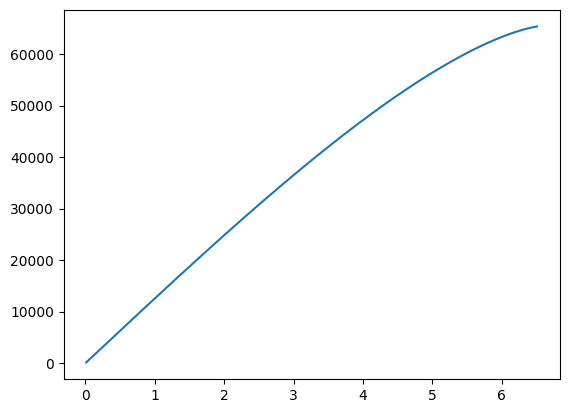

In [4]:
t_upperbound = 2*R/v - 0.1

x = []
timestamp = 0.01
while timestamp < t_upperbound:
    x.append(timestamp)
    timestamp += 0.01
y = []
for t in x:
    y.append(handout(R, N, v*t))
plt.plot(x, y, linestyle='-')

# Utils

# Experiment Setup

The time step is 1 ms

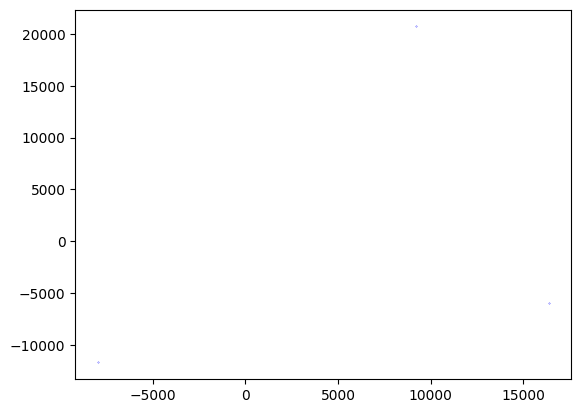

In [5]:
# uniform devices generator
def generate_points(n, R, x, y):
    def generate_one(R,x,y):
        r = R * math.sqrt(random.uniform(0, 1))
        theta = random.uniform(0, 1) * 2 * math.pi
        px = x + r * math.cos(theta)
        py = y + r * math.sin(theta)
        return (px, py)
    points = []
    for i in range(n):
        points.append(generate_one(R,x,y))
    return points

SATELLITE_R = 25 * 1000
NUMBER_UE = 3
SATELLITE_V = 7.56 * 1000
POSITIONS = generate_points(NUMBER_UE, SATELLITE_R-1*1000, 0, 0)
x_coords, y_coords = zip(*POSITIONS)
plt.scatter(x_coords, y_coords, color='blue', s = 0.05)
plt.show()

# Design Idea

## Communication Channel

1. The sender should wait the time and put the message in the receiver's Q
2. The sending action should through method "send_message()"

## Signal Processing

1. The processing of the signal is using CPU tasks

## Identity management

1. Each device including satellite will have a unique identifier (Not implemented)

## Message format

1. The message should follow the same format (Not implemented)

# Handover Protocol

In [6]:
SATELLITE_GROUND_DELAY = 50
SATELLITE_SATELLITE_DELAY = 10

## UE Class

In [7]:
class UE(object):
    def __init__(self,
                 identity,
                 position_x,
                 position_y,
                 serving_satellite,
                 satellite_ground_delay,
                 env):

        # Config Initialization
        self.identity = identity
        self.position_x = position_x
        self.position_y = position_y
        self.env = env
        self.serving_satellite = serving_satellite
        self.satellite_ground_delay = satellite_ground_delay

        # Logic Initialization
        self.active = True
        self.hasNoHandoverConfiguration = True
        self.hasNoHandoverRequest = True
        self.responseQ = simpy.Store(env)

        # Running Process
        env.process(self.init())
        env.process(self.handover_request_monitor())
        env.process(self.service_monitor())
        env.process(self.response_monitor())

    def init(self):
        print(
            f"UE {self.identity} deployed at time {self.env.now}, positioned at ({self.position_x},{self.position_y})")
        yield self.env.timeout(1)

    def send_message(self, delay, msg, Q, target):
        print(f"UE {self.identity} sends {target.identity}: message {msg} at {self.env.now}")
        yield self.env.timeout(delay)
        Q.put(msg)

    def handover_request_monitor(self):
        while self.active:
            d = math.sqrt(((self.position_x - self.serving_satellite.position_x) ** 2) + (
                    (self.position_y - self.serving_satellite.position_y) ** 2))

            if (d > 23 * 1000 and self.position_x < self.serving_satellite.position_x
                    and self.hasNoHandoverConfiguration and self.hasNoHandoverRequest):
                data = {
                    "type": "handover request",
                    "ueid": self.identity
                }
                msg = json.dumps(data)
                self.env.process(
                    self.send_message(self.satellite_ground_delay, msg, self.serving_satellite.handover_request_Q,
                                      self.serving_satellite))
                self.hasNoHandoverRequest = False
            else:
                yield self.env.timeout(1)

    def response_monitor(self):
        msg = yield self.responseQ.get()
        # yield self.env.timeout(self.delay)
        satid = json.loads(msg)['satid']
        if satid == self.serving_satellite.identity and self.active:
            self.hasNoHandoverConfiguration = False
            print(f"UE {self.identity} receives the configuration at {self.env.now}")

    def service_monitor(self):
        while True:
            d = math.sqrt(((self.position_x - self.serving_satellite.position_x) ** 2) + (
                    (self.position_y - self.serving_satellite.position_y) ** 2))
            if d >= 25 * 1000:
                print(
                    f"UE {self.identity} lost connection at time {self.env.now} from satellite {self.serving_satellite.identity}")
                self.active = False
                break
            else:
                yield self.env.timeout(1)  # Wait for 1 time unit before testing again


## Satellite Class

In [8]:
class Satellite(object):
    def __init__(self,
                 identity,
                 position_x,
                 position_y,
                 velocity,
                 satellite_ground_delay,
                 target_satellite,
                 ISL_delay,
                 env):

        # Config Initialization
        self.ISL_delay = ISL_delay
        self.target_satellite = target_satellite
        self.satellite_ground_delay = satellite_ground_delay
        self.identity = identity
        self.env = env
        self.position_x = position_x
        self.position_y = position_y
        self.velocity = velocity

        # Logic Initialization
        self.handover_request_Q = simpy.Store(env)
        self.configuration_response_Q = simpy.Store(env)
        self.UEs = {}
        self.cpus = simpy.Resource(env, 8)  # Concurrent processing

        # Running process
        self.env.process(self.init())  # Print Deployment information
        self.env.process(self.update_position())
        self.env.process(self.process_handover_request())

    def init(self):
        print(f"Satellite {self.identity} deployed at time {self.env.now}")
        yield self.env.timeout(1)

    def send_message(self, delay, msg, Q, target):
        print(f"Satellite {self.identity} sends {target.identity}: message {msg} at {self.env.now}")
        yield self.env.timeout(delay)
        Q.put(msg)

    # The satellite receives the handover request from the UE
    def process_handover_request(self):
        while True:
            msg = yield self.handover_request_Q.get()
            print(f"Satellite {self.identity} receives msg:{msg} at time {self.env.now}")
            sender = json.loads(msg)['ueid']
            self.env.process(self.cpu_processing(sender))

    def process_configuration_response(self):
        while True:
            msg = yield self.handover_request_Q.get()
            print(f"Satellite {self.identity} receives msg:{msg} at time {self.env.now}")
            sender = json.loads(msg)['ueid']
            self.env.process(self.cpu_processing(sender))

    def cpu_processing(self, ueid):
        with self.cpus.request() as request:
            UE = self.UEs[ueid]
            if UE.active:
                yield request
                yield self.env.timeout(1)
            if UE.active:
                # return the response to UE
                data = {
                    "type": "handover request response",
                    "satid": self.identity,
                    "ueid": UE.identity}
                msg = json.dumps(data)
                self.env.process(self.send_message(self.satellite_ground_delay, msg, UE.responseQ, UE))
            #   print(f"Satellite {self.identity} sends response {res} at time {env.now}")

    def update_position(self):
        while True:
            yield self.env.timeout(1)  # Time between position updates
            # Update x and y based on velocity
            # Calculate time ratio
            ratio = 1 / 1000
            # direction set to right
            self.position_x += self.velocity * ratio

        # For convenience, the target satellite is first separated.


class targetSatellite(object):
    def __init__(self, identity, x, y, v, ISL_delay, env):
        self.ISL_delay = ISL_delay
        self.identity = identity
        self.env = env
        self.x = x
        self.y = y
        self.v = v
        # This Q is for computing the response to source satellite
        self.configure_request_Q = simpy.Store(env)

        self.cpus = simpy.Resource(env, 8)  # Concurrent processing

        self.env.process(self.init())

    # self.env.process(self.process_handover_request())

    def init(self):
        print(f"Satellite {self.identity} deployed at time {self.env.now}")
        yield self.env.timeout(1)

    def process_configuration_request(self):
        while True:
            msg = yield self.configureQ.get()
            print(f"Satellite {self.identity} receives msg:{msg} at time {self.env.now}")
            # sender = msg[]
            self.env.process(self.cpu_processing())

# Running Experiment

In [9]:
POSITIONS = [(-13000, -20711),(-13000, -20711), (-13000,20711)]

env = simpy.Environment()
# Deploy Satellites
satellite2 = targetSatellite(2, 0, 0, SATELLITE_V, SATELLITE_SATELLITE_DELAY, env)

satellite1 = Satellite(
    identity=1,
    position_x=0,
    position_y=0,
    velocity=SATELLITE_V,
    satellite_ground_delay=SATELLITE_GROUND_DELAY,
    target_satellite=satellite2,
    ISL_delay=SATELLITE_SATELLITE_DELAY,
    env=env)

# Deploying UEs following randomly generated positions
for index, position in enumerate(POSITIONS, start=1):
    satellite1.UEs[index] = UE(
        identity=index,
        position_x=position[0],
        position_y=position[1],
        serving_satellite=satellite1,
        satellite_ground_delay=SATELLITE_GROUND_DELAY,
        env=env)
    
env.run(until=5000)

Satellite 2 deployed at time 0
Satellite 1 deployed at time 0
UE 1 deployed at time 0, positioned at (-13000,-20711)
UE 2 deployed at time 0, positioned at (-13000,-20711)
UE 3 deployed at time 0, positioned at (-13000,20711)
UE 1 sends 1: message {"type": "handover request", "ueid": 1} at 0
UE 2 sends 1: message {"type": "handover request", "ueid": 2} at 0
UE 3 sends 1: message {"type": "handover request", "ueid": 3} at 0
Satellite 1 receives msg:{"type": "handover request", "ueid": 1} at time 50
Satellite 1 receives msg:{"type": "handover request", "ueid": 2} at time 50
Satellite 1 receives msg:{"type": "handover request", "ueid": 3} at time 50
Satellite 1 sends 1: message {"type": "handover request response", "satid": 1, "ueid": 1} at 51
Satellite 1 sends 2: message {"type": "handover request response", "satid": 1, "ueid": 2} at 51
Satellite 1 sends 3: message {"type": "handover request response", "satid": 1, "ueid": 3} at 51
UE 1 receives the configuration at 101
UE 2 receives the 

# Result Analysis

In [10]:
UEs = []
for ueid in satellite1.UEs:
    UEs.append(satellite1.UEs[ueid])

In [11]:
counter_request = 0
counter_success = 0
for ue in UEs:
    if ue.hasNoHandoverRequest == False:
        counter_request += 1
    if ue.hasNoHandoverConfiguration == False:
        counter_success += 1
print(f"{counter_request} UEs sent the handover requests")
print(f"{counter_success} UEs received the handover configuration")

3 UEs sent the handover requests
3 UEs received the handover configuration
